In [1]:
! pip install transformers datasets

In [2]:
!pip install transformers datasets evaluate

In [3]:
from datasets import load_dataset

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
food = load_dataset("imagefolder", data_dir="/Users/adesai/Desktop/Recipe/dataset")

Resolving data files:   0%|          | 0/90 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/adesai/.cache/huggingface/datasets/imagefolder/default-c1c282200e5d0b50/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 90
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 30
    })
})

In [7]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [8]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

2023-04-22 19:45:21.973192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

In [10]:
import numpy as np
import tensorflow as tf
from PIL import Image


def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [11]:
food["train"].set_transform(preprocess_train)
food["test"].set_transform(preprocess_val)

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [13]:
import evaluate

accuracy = evaluate.load("accuracy")

In [14]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [15]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
num_train_steps = len(food["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [16]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# converting our train dataset to tf.data.Dataset
tf_train_dataset = food["train"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["label"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = food["test"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["label"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [18]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [19]:
import os
print(os.getcwd())

/Users/adesai/Desktop/Recipe


In [20]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)
save_callback = keras.callbacks.ModelCheckpoint(
    'checkpoint/',
    save_weights_only = False,
    monitor = 'accuracy',
    save_best_only = False
)
callbacks = [metric_callback, save_callback]

In [21]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/5


2023-04-22 19:45:36.619773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [90]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:45:36.620346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [90]
	 [[{{node Placeholder/_0}}]]


6/6 [==============================] - ETA: 0s - loss: 1.7590

2023-04-22 19:46:43.852966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [30]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:46:43.853199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [30]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:46:51.879976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [16,3,224,22

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


6/6 [==============================] - 109s 17s/step - loss: 1.7590 - val_loss: 1.6876 - accuracy: 0.5667
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 1.6228

2023-04-22 19:48:22.632765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [16,3,224,224]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:48:25.739978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [14,3,224,224]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:48:32.653769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and 

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


6/6 [==============================] - 87s 15s/step - loss: 1.6228 - val_loss: 1.5964 - accuracy: 0.8333
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 1.5145

2023-04-22 19:49:50.990436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [16,3,224,224]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:49:54.015599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [14,3,224,224]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:50:00.682435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and 

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


6/6 [==============================] - 87s 15s/step - loss: 1.5145 - val_loss: 1.5048 - accuracy: 0.9333
Epoch 4/5
6/6 [==============================] - ETA: 0s - loss: 1.3938

2023-04-22 19:51:15.643893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [16,3,224,224]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:51:18.489471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [14,3,224,224]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:51:24.489359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and 

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


6/6 [==============================] - 83s 14s/step - loss: 1.3938 - val_loss: 1.4118 - accuracy: 0.9667
Epoch 5/5
6/6 [==============================] - ETA: 0s - loss: 1.2936

2023-04-22 19:52:41.175823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [16,3,224,224]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:52:44.184069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [14,3,224,224]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:52:51.604449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and 

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


6/6 [==============================] - 87s 15s/step - loss: 1.2936 - val_loss: 1.3234 - accuracy: 1.0000


In [40]:
ds = load_dataset("imagefolder", data_dir="/Users/adesai/Desktop/Recipe/dataset", split="test")
image = ds["image"][6]

Resolving data files:   0%|          | 0/90 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [41]:
ds

Dataset({
    features: ['image', 'label'],
    num_rows: 30
})

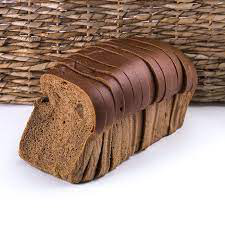

In [42]:
image

In [35]:
img = Image.open("/Users/adesai/Desktop/Recipe/test.jpg")
image = img

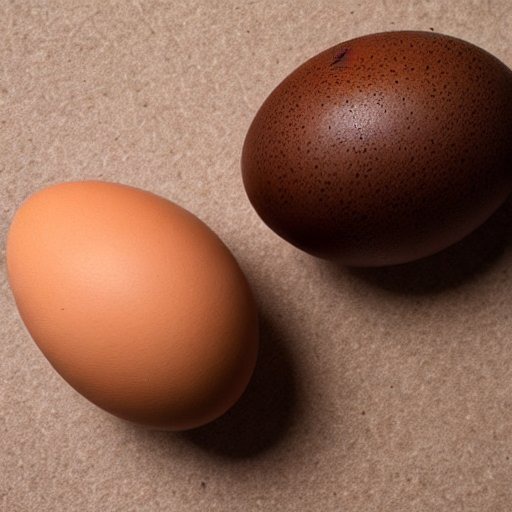

In [36]:
image

In [43]:
image = val_data_augmentation(convert_to_tf_tensor(image.convert("RGB")))
image = tf.transpose(tf.squeeze(image))
image = tf.expand_dims(image, 0)

In [44]:
prediction = model(image)
predicted_class_idx = tf.argmax(prediction.logits, axis=-1).numpy()[0]
predicted_class = id2label[str(predicted_class_idx)]

print(f"The predicted class is {predicted_class}")

The predicted class is bread


In [30]:
tf.saved_model.save(model, 'saved/')

2023-04-22 20:00:45.558468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and shape [?,?,?,?]
	 [[{{node pixel_values}}]]
2023-04-22 20:00:47.688470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and shape [?,?,?,?]
	 [[{{node pixel_values}}]]
2023-04-22 20:00:47.837465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and shape [?,?,?,?]
	 

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


In [33]:
loaded_model = tf.saved_model.load('/Users/adesai/Desktop/Recipe/saved')

In [34]:
prediction = loaded_model(image)
predicted_class_idx = tf.argmax(prediction.logits, axis=-1).numpy()[0]
predicted_class = id2label[str(predicted_class_idx)]

print(f"The predicted class is {predicted_class}")

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (8 total):
    * <tf.Tensor 'pixel_values:0' shape=(1, 3, 224, 224) dtype=float32>
    * None
    * None
    * None
    * None
    * None
    * None
    * False
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (8 total):
    * {'pixel_values': TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name='pixel_values_pixel_values')}
    * None
    * None
    * None
    * None
    * None
    * None
    * True
  Keyword arguments: {}

Option 2:
  Positional arguments (8 total):
    * {'pixel_values': TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name='pixel_values_pixel_values')}
    * None
    * None
    * None
    * None
    * None
    * None
    * False
  Keyword arguments: {}

In [38]:
model.summary()

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 85,803,270
Trainable params: 85,803,270
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.save('/Users/adesai/Desktop/Recipe/testing')

2023-04-22 21:03:51.967443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and shape [?,?,?,?]
	 [[{{node pixel_values}}]]
2023-04-22 21:03:54.403680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and shape [?,?,?,?]
	 [[{{node pixel_values}}]]
2023-04-22 21:03:54.634843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pixel_values' with dtype float and shape [?,?,?,?]
	 

INFO:tensorflow:Assets written to: /Users/adesai/Desktop/Recipe/testing/assets


INFO:tensorflow:Assets written to: /Users/adesai/Desktop/Recipe/testing/assets
